----

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
date_col = ['DateCrawled', 'DateCreated', 'LastSeen']
df = pd.read_csv('/datasets/autos.csv', parse_dates=date_col)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [3]:
print('Quantity of duplicates is', df.duplicated().sum())
df.drop_duplicates(inplace=True)

Quantity of duplicates is 4


## 1.1 Анализ аномалий в данных 

Построим гистограмму по всем числовым колонкам.

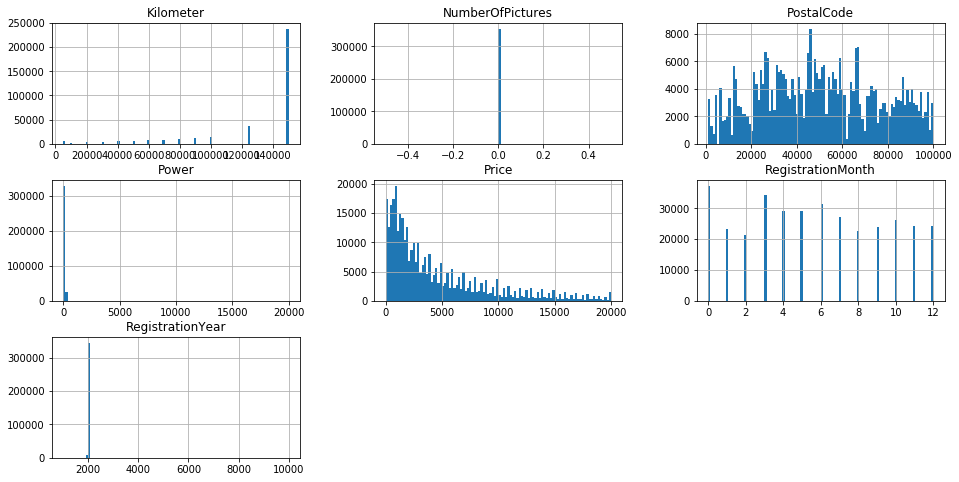

In [4]:
df.hist(figsize=(16,8), bins=100)
plt.show()

Данные выглядят так, что с каждым полем хочется разбираться.

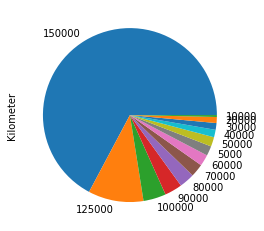

In [5]:
column = 'Kilometer'
df[column].value_counts().plot(kind='pie')
plt.show()
df.drop(columns=column, inplace=True)

Так как почти все значения стольба попадают на одну цифру, вряд ли мы сможем извлечь пользу из таких данных при обучении модели. Думаю мы можем сразу удалить этот столбец.

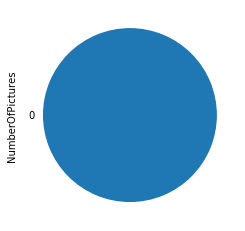

In [6]:
column = 'NumberOfPictures'
df[column].value_counts().plot(kind='pie')
plt.show()
df.drop(columns=column, inplace=True)

С количеством фото еще проще, их просто нет. В реальной жизни я бы пошел к тому кто делал эту выгрузку и спросил почему здесь нули, но сейчас такой возможности нет, значит просто удалим этот столбец.

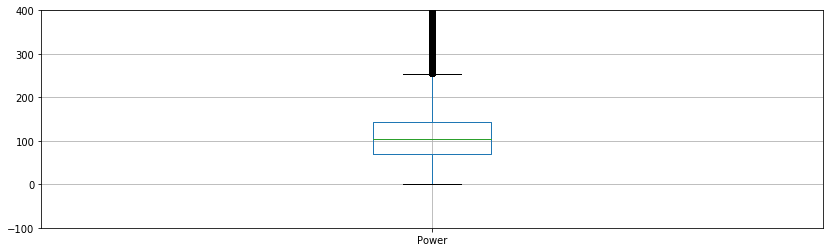

Количество выбросов свыше 250 сил - 7453
Количество выбросов равное нулю - 40225


In [7]:
column = 'Power'
df.boxplot(column=column, figsize=(14,4))
plt.ylim(-100, 400)
plt.show()
print('Количество выбросов свыше 250 сил -', df[df[column] > 250][column].count())
print('Количество выбросов равное нулю -', df[df[column] == 0][column].count())
df.drop(columns=column, inplace=True)

Слишком много выбросов у этого поля, и если мы будем и в реальности получать такие данные от пользователей, пожалуй работа модели может быть очень не стабильной. Лучше будет не использовать это поле при обучении модели.

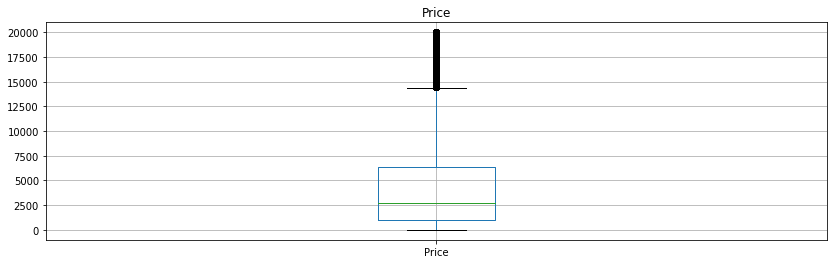

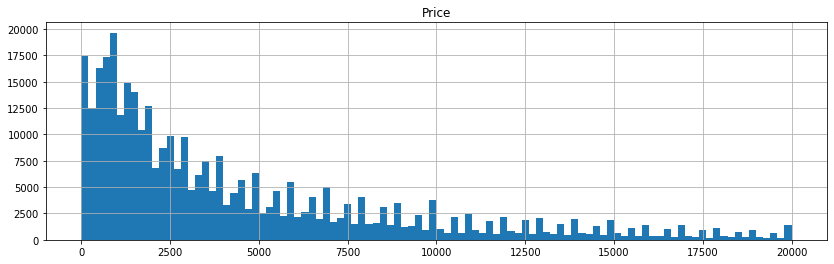

Количество строк равное нулю - 10772


In [8]:
column = 'Price'
df.boxplot(column=column, figsize=(14,4))
plt.title(column)
plt.show()
df[column].hist(bins=100, figsize=(14,4))
plt.title(column)
plt.show()
print('Количество строк равное нулю -', df[df[column] == 0][column].count())

df = df[df[column] > 0]


Трудно сказать почему мы имеем нули в цене, может забали ввести цену, а может это подарок. На для нашей модели, которая занимается предсказанием цены, такие данные нам вряд ли могут помочь. Поэтому предлагаю удалить эти 10 тыс. строк с нулевой ценой.

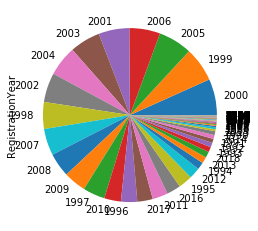

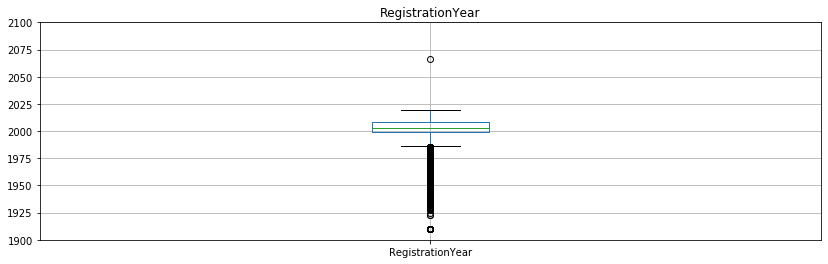

Год больше 2020 - 86
Год меньше 1900 - 53


In [9]:
column = 'RegistrationYear'
df[column].value_counts().plot(kind='pie')
plt.show()
df.boxplot(column=column, figsize=(14,4))
plt.title(column)
plt.ylim(1900,2100)
plt.show()
print('Год больше 2020 -', df[df[column] > 2020][column].count())
print('Год меньше 1900 -', df[df[column] <1900][column].count())
df = df.query('1900 < RegistrationYear < 2020')

Избавимся от выбросов в этом поле.

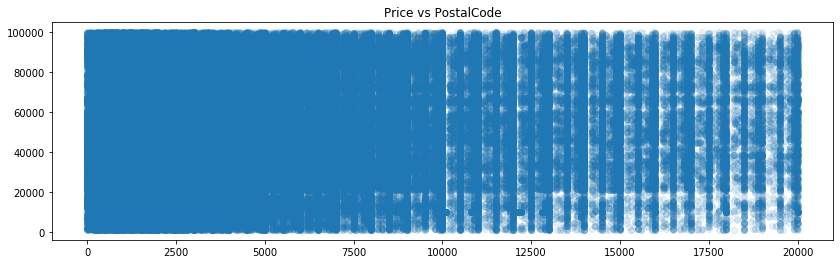

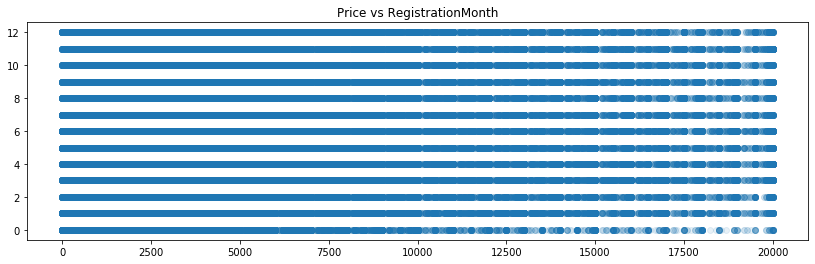

In [10]:
plt.figure(figsize=(14,4))
plt.scatter(df['Price'], df['PostalCode'], alpha=0.1)
plt.title('Price vs PostalCode')
plt.show()

plt.figure(figsize=(14,4))
plt.scatter(df['Price'], df['RegistrationMonth'], alpha=0.1)
plt.title('Price vs RegistrationMonth')
plt.show()

In [11]:
drop_column = ['PostalCode', 'RegistrationMonth', 'DateCrawled', 'DateCreated', 'LastSeen']
df.drop(columns=drop_column, inplace=True)

Поля почтовый год и месяц регистрации удалим, так как данные почти равномерно распределены между значениями этих полей что вполне логично исходя из сути этих полей.

Также удалим поля с датами что бы избавиться от лишней информации.

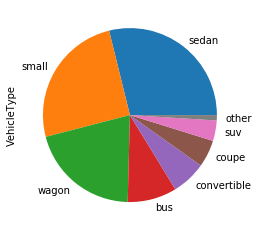

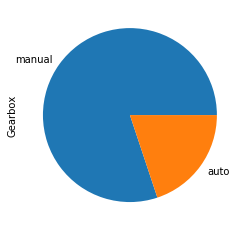

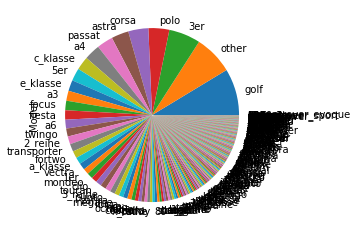

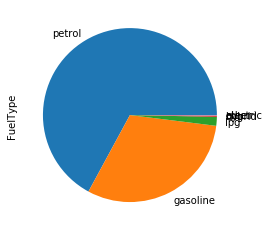

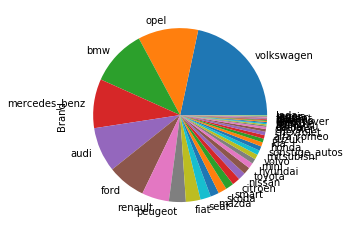

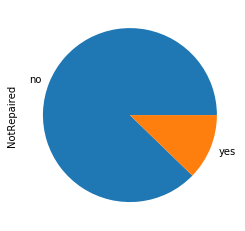

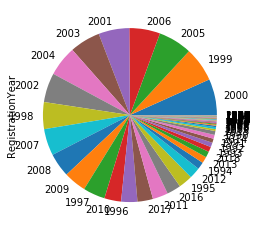

In [12]:
categorical = [
    'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired',
    'RegistrationYear'
]

for column in categorical:
    df[column].value_counts().plot(kind='pie', figsize=(14,4))
    plt.show()

## 1.2 Пропуски в данных

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343454 entries, 0 to 354368
Data columns (total 8 columns):
Price               343454 non-null int64
VehicleType         309843 non-null object
RegistrationYear    343454 non-null int64
Gearbox             326211 non-null object
Model               325986 non-null object
FuelType            314098 non-null object
Brand               343454 non-null object
NotRepaired         277706 non-null object
dtypes: int64(2), object(6)
memory usage: 23.6+ MB


В данных остается еще достаточно пропусков, однако кажется логичным не заполнять из сейчас, так как этим пропуски скроей всего следствие того, что люди при заполненении анкеты не заполняют эти поля. А значит в реальной жизни нас ждет тоже самое и нужно учить модели с учетом этого.

Сами пропуски мы заполним отельно котегорией при конвертации номинальных значений в цифровые.

## 1.3 Дубликаты

In [14]:
print('Quantity of duplicates is', df.duplicated().sum())
# df.drop_duplicates(inplace=True)


Quantity of duplicates is 82199


Дубликатов у нас сейчас 82 тыс. Однако сначала мы проверяли и их было всего 4 записи, это значит что записи просто похожи, и когда мы удалили лишние поля, эти строки стали похожи на дубликаты.
Удалять из не стоит.

## 1.4 Конвертация данных

In [15]:
categorical = [
    'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired',
    'RegistrationYear'
]

factorized = []
for column in categorical:
    new_name = column + '_int'
    df[new_name] = df[column].factorize()[0]
    factorized.append(new_name)
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 343454 entries, 0 to 354368
Data columns (total 15 columns):
Price                   343454 non-null int64
VehicleType             309843 non-null object
RegistrationYear        343454 non-null int64
Gearbox                 326211 non-null object
Model                   325986 non-null object
FuelType                314098 non-null object
Brand                   343454 non-null object
NotRepaired             277706 non-null object
VehicleType_int         343454 non-null int64
Gearbox_int             343454 non-null int64
Model_int               343454 non-null int64
FuelType_int            343454 non-null int64
Brand_int               343454 non-null int64
NotRepaired_int         343454 non-null int64
RegistrationYear_int    343454 non-null int64
dtypes: int64(9), object(6)
memory usage: 41.9+ MB


In [16]:
data = df[[
    'Price', 'VehicleType_int', 'Gearbox_int',
   'Model_int', 'FuelType_int', 'Brand_int', 'NotRepaired_int',
   'RegistrationYear_int'
]]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343454 entries, 0 to 354368
Data columns (total 8 columns):
Price                   343454 non-null int64
VehicleType_int         343454 non-null int64
Gearbox_int             343454 non-null int64
Model_int               343454 non-null int64
FuelType_int            343454 non-null int64
Brand_int               343454 non-null int64
NotRepaired_int         343454 non-null int64
RegistrationYear_int    343454 non-null int64
dtypes: int64(8)
memory usage: 23.6 MB


,Price,VehicleType_int,Gearbox_int,Model_int,FuelType_int,Brand_int,NotRepaired_int,RegistrationYear_int
0,480,-1,0,0,0,0,-1,0
1,18300,0,0,-1,1,1,0,1
2,9800,1,1,1,1,2,-1,2
3,1500,2,0,0,0,0,1,3
4,3600,2,0,2,1,3,1,4


In [17]:
target = data['Price']
features = data.drop(columns='Price')
print('target - ', target.shape)
print('features -', features.shape)

target -  (343454,)
features - (343454, 7)


## Вывод 

Мы убрали выбросы, перевели категориальные признаки из номинальных в числовые, удалили дубликаты и убрали все лишние столбцы. При этом мы потеряли всего 10 тыс. строк, что для нашей базы около трех процентов. Посмотрим что будет при обучении моделей.

# 2. Обучение моделей

In [18]:
features_train, features_valid, target_train,  target_valid = train_test_split(
    data.drop(columns='Price'), data['Price'], random_state=12345, test_size=0.4
)

features_test, features_valid, target_test, target_valid = train_test_split(
     features_valid, target_valid, random_state=12345, test_size=0.5
)

print('data shape is -', data.shape)
print('features_train shape is -', features_train.shape)
print('target_train shape is -', target_train.shape)
print('features_valid shape is -', features_valid.shape)
print('target_valid shape is -', target_valid.shape)
print('features_test shape is -', features_test.shape)
print('target_test shape is -', target_test.shape)

assert (
    data.shape[0] 
    - target_train.shape[0] 
    - target_valid.shape[0] 
    - target_test.shape[0]
) == 0


data shape is - (343454, 8)
features_train shape is - (206072, 7)
target_train shape is - (206072,)
features_valid shape is - (68691, 7)
target_valid shape is - (68691,)
features_test shape is - (68691, 7)
target_test shape is - (68691,)


In [19]:
train_data = lgb.Dataset(
    features_train, label=features_valid, feature_name=features_train.columns, categorical_feature=factorized
)


## LightGBM

In [20]:
start = time.time()

params = {
    'metric': 'rmse',
    'max_depth': 30, 
    'learning_rate': 0.05,
    'verbose': 0,
}

train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=factorized)
valid_data = lgb.Dataset(features_valid, label=target_valid)

light_gbm_model = lgb.train(
    params,
    train_data,
    valid_sets=valid_data,
    num_boost_round=200,
    verbose_eval=20,
)

predicted = light_gbm_model.predict(features_valid)
print(f'rmse is {mean_squared_error(target_valid, predicted)**.5:,.0f}')
print(f'Total time is {time.time() - start:.2f}')

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand_int', 'FuelType_int', 'Gearbox_int', 'Model_int', 'NotRepaired_int', 'RegistrationYear_int', 'VehicleType_int']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	valid_0's rmse: 2676.09
[40]	valid_0's rmse: 2200.53
[60]	valid_0's rmse: 2071.05
[80]	valid_0's rmse: 2022.15
[100]	valid_0's rmse: 1997.96
[120]	valid_0's rmse: 1983.25
[140]	valid_0's rmse: 1974.13
[160]	valid_0's rmse: 1967.63
[180]	valid_0's rmse: 1960.8
[200]	valid_0's rmse: 1955.93
rmse is 1,956
Total time is 22.99


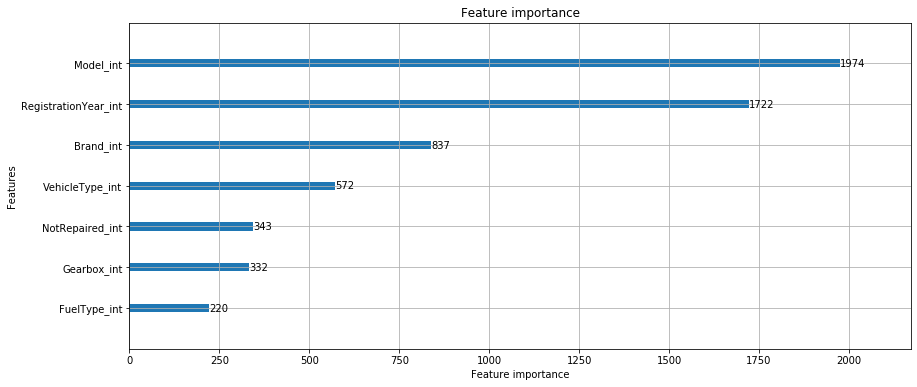

In [21]:
lgb.plot_importance(light_gbm_model, figsize=(14,6))
plt.show()

Самые важные переменные это год выпуска, модель и марка. Выглядит вполне логично.

## CatBoost 

In [22]:
start = time.time()
cat_boost_model = CatBoostRegressor(loss_function="RMSE", iterations=200)
cat_boost_model.fit(features_train, target_train, cat_features=factorized, verbose=10)

predicted = cat_boost_model.predict(features_valid)
print(f'rmse is {mean_squared_error(target_valid, predicted)**.5:,.0f}')
print(f'Total time is {time.time() - start:.2f}')

0:	learn: 4439.0279645	total: 765ms	remaining: 2m 32s
10:	learn: 3764.9975093	total: 5.94s	remaining: 1m 42s
20:	learn: 3291.4360267	total: 11.2s	remaining: 1m 35s
30:	learn: 2965.2143316	total: 16.1s	remaining: 1m 27s
40:	learn: 2746.2088414	total: 21.2s	remaining: 1m 22s
50:	learn: 2598.5255945	total: 25.8s	remaining: 1m 15s
60:	learn: 2501.0774932	total: 30.5s	remaining: 1m 9s
70:	learn: 2433.2044427	total: 35.5s	remaining: 1m 4s
80:	learn: 2383.9839482	total: 40.8s	remaining: 59.9s
90:	learn: 2350.1426663	total: 46.1s	remaining: 55.2s
100:	learn: 2326.2125123	total: 51.3s	remaining: 50.3s
110:	learn: 2303.8697902	total: 56.7s	remaining: 45.4s
120:	learn: 2287.4971830	total: 1m 2s	remaining: 40.9s
130:	learn: 2274.6356130	total: 1m 8s	remaining: 36.1s
140:	learn: 2263.6003374	total: 1m 13s	remaining: 30.8s
150:	learn: 2253.5285039	total: 1m 19s	remaining: 25.8s
160:	learn: 2243.9857926	total: 1m 24s	remaining: 20.6s
170:	learn: 2235.6298207	total: 1m 30s	remaining: 15.4s
180:	learn:

In [23]:
cat_boost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RegistrationYear_int,46.122407
1,Brand_int,14.095624
2,VehicleType_int,12.539093
3,Model_int,12.273887
4,Gearbox_int,8.502656
5,NotRepaired_int,5.766528
6,FuelType_int,0.699805


Интересно получается, у первой модели самы важные параметры это модель\марка и год регистрации. Тогда как у второй модели самый важный параметр это год регистрации, а модель только на четвертом месте.

## Вывод
Попробовал разные параметры, те что есть мне показались оптимальными по качестку и времени. В итоге в большинстве случаев LightGBM показывала большую точность чем CatBoost, но при этом вторая была быстрее, почти во всех случаях.
Возможно убучение было долгим а работа будет быстрой? Итогда не страшно что обучается долго, главное что работает быстро. Давайте это проверим!

# 3. Анализ моделей

Давайте оценим качество работы моделей на тестовых данных.

In [24]:
start = time.time()
predicted = light_gbm_model.predict(features_test)
rmse_1 = mean_squared_error(target_test, predicted)**.5
print(f'rmse модели LightGBM {rmse_1:,.0f}')
print(f'Скорость работы обучнной модели {time.time() - start:.1f}')

start = time.time()
predicted = cat_boost_model.predict(features_test)
rmse_2 = mean_squared_error(target_test, predicted)**.5
print(f'rmse модели CatBoost {rmse_2:,.0f}')
print(f'Скорость работы обучнной модели {time.time() - start:.1f}')
print(f'LightGBM передсказывает точннее на {(rmse_2 - rmse_1) /rmse_2:.2%}')

rmse модели LightGBM 1,942
Скорость работы обучнной модели 2.5
rmse модели CatBoost 2,172
Скорость работы обучнной модели 0.4
LightGBM передсказывает точннее на 10.56%


# Вывод
На тестовых данных LightGBM работает долго. CatBoost работает почти в разы быстрее. 

Зато качество лучше у LightGBM. Хорошо это или плохо? 

Если бы мы рассматривали вопрос выдачи ипотеки, где цена ошибки стоит дорого, а количество заявок в минуту имеет какие-то осязаемые размеры, мы бы скорей всего выбрали LightGBM. Пусть она работает долго, зато точнее. Можно было бы купить серверов побольше и смириться с этим. 

Однако в нашем случае, мы даем примерную оценку пользователю его автомобиля и 5-10 процентов точности вряд ли сыграют такую большую роль. А вот если сайт будет грузится в три раза дольше, это может быть проблемой. Как бы хорошо мы не предсказали в таком случае, пользователь может об этом просто никогда не узнать.

-------